# 1A: The elements of the most basic run file

In this notebook we will introduce how to set up an example run in a Jupyter notebook with ipyparallel.

## Recursively copy the contents of the example run directory to a clean folder in the docker container

We'll also override the input namelist of the reference run directory.

In [1]:
import os
import shutil

In [2]:
REFERENCE = "reference_rundir"
RUNDIR = "rundir_1"

if os.path.isdir(RUNDIR):
    shutil.rmtree(RUNDIR)
shutil.copytree(REFERENCE, RUNDIR);
shutil.copy("input_1.nml", os.path.join(RUNDIR, "input.nml"));

## Start the ipyparallel session for the notebook

This involves running a couple shell commands (hence the `%%bash` cell magic command at the top of the following cell); note this means these commands are executed in the shell rather than the notebook.

In [3]:
%%bash
# if you get a crash, add --debug to this command to put more info in logs
# logs are in /root/.ipython/profile_mpi/log
ipcluster start --profile=mpi -n 6 --daemonize
sleep 10  # command is asynchronous, so let's wait to avoid an error in the next cell

In [4]:
import ipyparallel as ipp
rc = ipp.Client(profile='mpi', targets='all', block=True)
dv = rc[:]
dv.activate()
dv.block = True

In [5]:
print("Running IPython Parallel on {0} MPI engines".format(len(rc.ids)))
print("Commands in the following cells will be executed in parallel (disable with %autopx)")
%autopx

Running IPython Parallel on 6 MPI engines
Commands in the following cells will be executed in parallel (disable with %autopx)
%autopx enabled


## Use `mpi4py` gain access to the communicator for the notebook.

Using the `size` and `rank` attributes of the communicator we show the number of MPI ranks we are running the notebook with, as well as the rank of the particular process.  There are different output streams for the different ranks.

In [6]:
from mpi4py import MPI

comm = MPI.COMM_WORLD
mpi_size = comm.size
mpi_rank = comm.rank

print(f"Number of ranks is {mpi_size}.")
print(f"I am rank {mpi_rank}.")

[stdout:0] 
Number of ranks is 6.
I am rank 0.
[stdout:1] 
Number of ranks is 6.
I am rank 1.
[stdout:2] 
Number of ranks is 6.
I am rank 2.
[stdout:3] 
Number of ranks is 6.
I am rank 3.
[stdout:4] 
Number of ranks is 6.
I am rank 4.
[stdout:5] 
Number of ranks is 6.
I am rank 5.


## Enter the run directory

Next we move into the run directory we created.  Note that we need to re-import `os` and re-define any variables we created before we started the cluster.  `fv3gfs.wrapper` requires that its routines are called from within a valid run directory.

In [7]:
import os
RUNDIR = "rundir_1"
os.chdir(RUNDIR)

if mpi_rank == 0:
    print(os.listdir("."))

[stdout:0] ['.DS_Store', '._.DS_Store', 'INPUT', 'README.md', 'RESTART', 'aerosol.dat', 'co2historicaldata_2010.txt', 'co2historicaldata_2011.txt', 'co2historicaldata_2012.txt', 'co2historicaldata_2013.txt', 'co2historicaldata_2014.txt', 'co2historicaldata_2015.txt', 'co2historicaldata_2016.txt', 'data_table', 'diag_table', 'field_table', 'fv3.exe', 'fv3config.yml', 'global_o3prdlos.f77', 'grb', 'input.nml', 'sfc_emissivity_idx.txt', 'solarconstant_noaa_an.txt']


By listing the contents of the current directory on the zeroth rank, we can see what is needed in a run directory for FV3GFS.  This is everything that we would need to run the base fortran model.  There are a number of input files (e.g. `co2historicaldata_2*.txt`, the files in the `grb` directory, etc.) as well as some files used for configuring the model, e.g.:

- `input.nml` the input namelist for the model (all the parameter settings for the simulation)
- `diag_table` the specification of which diagnostics the model will output
- `field_table` the specification of the tracers that the model will use for microphysics or other purposes

`INPUT/` contains the initial conditions for the model.

## How is the model configured?

The main place to look at this is in the namelist.  There is a handy Python tool for doing this called `f90nml`: https://f90nml.readthedocs.io/en/latest/.  For instance we can look at the coupler namelist to find information about the start date of the run (`current_date`), the model timestep (`dt_atmos`), and the amount of time the model is configured to run for (in this case `hours = 1`).

In [8]:
import f90nml
namelist = f90nml.read("input.nml")

if comm.rank == 0:
    print(namelist["coupler_nml"])

[stdout:0] Namelist([('atmos_nthreads', 1), ('calendar', 'julian'), ('current_date', [2016, 8, 1, 0, 0, 0]), ('days', 0), ('dt_atmos', 900), ('dt_ocean', 900), ('hours', 1), ('memuse_verbose', True), ('minutes', 0), ('months', 0), ('ncores_per_node', 32), ('seconds', 0), ('use_hyper_thread', True)])


## Now we can run the model

We'll start by importing the `wrapper` and running the `initialize` method.  This allocates the necessary memory for the model, and loads in the intial conditions.

In [9]:
from fv3gfs import wrapper
wrapper.initialize()

Then to run the model for the amount of time specified in the namelist, we can write our own main loop in Python.  The wrapper contains a convenient method for computing the number of timesteps required to run for the length of time in the namelist, `wrapper.get_step_count` (in this case four steps).

In [10]:
if comm.rank == 0:
    print(wrapper.get_step_count())

[stdout:0] 4


The most basic main loop requires just three steps:
- `step_dynamics`
- `step_physics`
- `save_intermediate_restart_if_enabled`

These three steps, executed in this order within the main loop, ensure bit-for-bit reproducibility with the pure fortran model.

In [11]:
for i in range(wrapper.get_step_count()):
    wrapper.step_dynamics()
    wrapper.step_physics()
    wrapper.save_intermediate_restart_if_enabled()

Finally, when the loop is finished, we can call `wrapper.cleanup`.

In [12]:
wrapper.cleanup()

## Verify that the model ran by loading in diagnostics it produced

Diagnostics from the fortran model are output in netCDF files.  As currently configured, this simulation outputs one netCDF file per output category per cubed sphere tile.  In this simulation some diagnostics are configured to be stored every timestep in the `atmos_dt_atmos.tile{tile}.nc` output files.  With your favorite Python library (e.g. `netcdf4-python`, `xarray`), load one or more of these files and plot a variable to verify that the model ran.

We can disable the MPI parallelism for now.  Note this means that we are back in the root directory of the docker container again, so all file paths have to take this into account.

In [13]:
%autopx

%autopx disabled


In [14]:
import xarray as xr

In [15]:
ds = xr.open_mfdataset("rundir_1/atmos_dt_atmos.tile*.nc", concat_dim=["tile"], combine="nested")

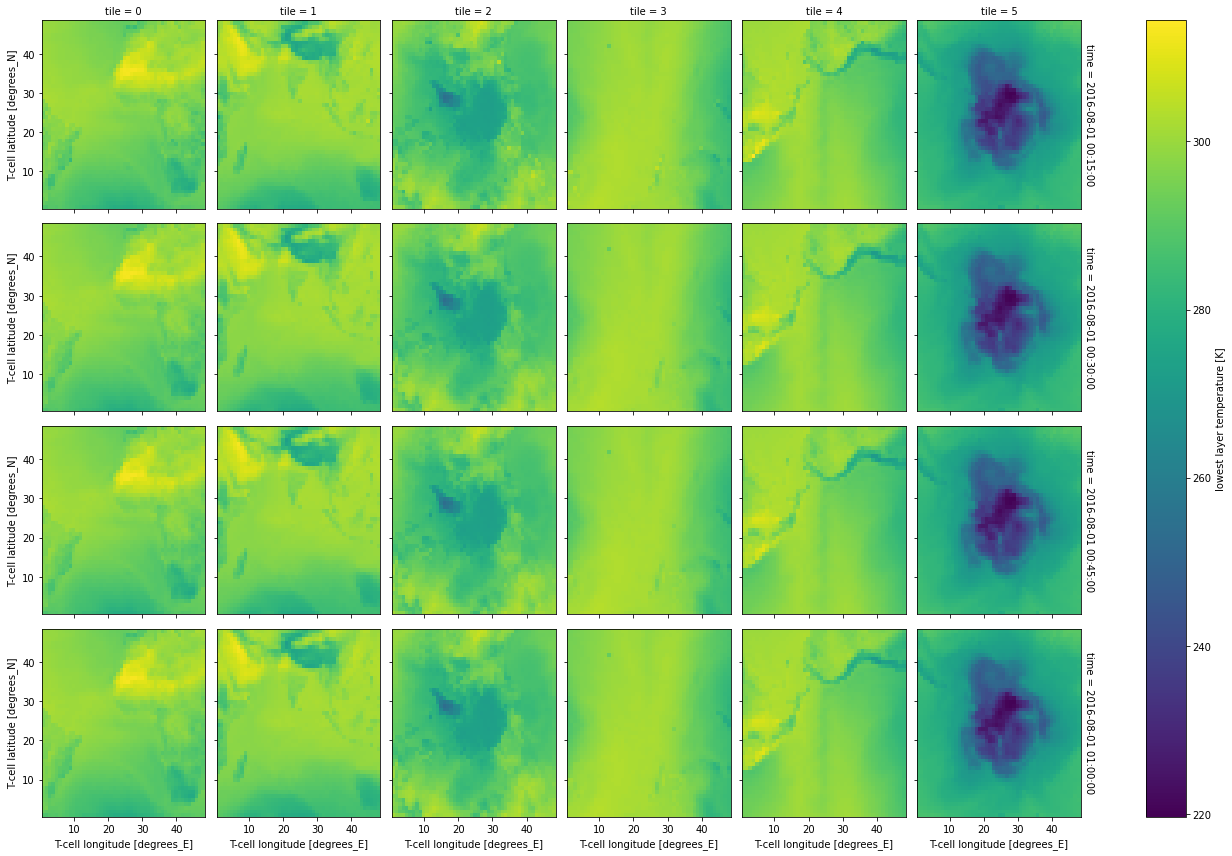

In [16]:
ds.TMPlowest.plot(row="time", col="tile")